In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import cmasher as cmr
import networkx as nx
%matplotlib inline


import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

import models
from models import Renorm_Dynamic
from EI_calculation import approx_ei
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')

from thop import profile
from torch.autograd.functional import jacobian

In [49]:
def EI_calculate_pdet(A, Sigma):
    """
    Calculate the Effective Information (EI) based on the pseudo-determinant.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    float: The logarithm of the pseudo-determinant (EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and return the product of singular values greater than 1e-10
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    pseudo_det = np.prod(s[s > 1e-10])  # Only consider non-zero singular values
    
    # Effective Information (EI) is the log of the pseudo-determinant scaled by constants
    EI = math.log(abs(pseudo_det)**(1/2) / (2 * np.pi * np.e)**(n / 2))
    
    return EI


def EI_calculate_m_star(A, Sigma, k):
    """
    Calculate the maximum Effective Information (max EI) using the first k singular values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    k (int): The number of singular values to consider.
    
    Returns:
    float: The logarithm of the pseudo-determinant using the top k singular values (max EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and take the product of the first k singular values
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    max_pseudo_det = np.prod(s[:k])
    
    # max EI is the log of the top k singular values' product, scaled by constants
    max_EI = math.log(abs(max_pseudo_det)**(1/2) / (2 * np.pi * np.e)**(k / 2))
    
    return max_EI

def Gamma(alpha, r_eps, A, Sigma):
    """
    Calculate the Gamma function based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, of size n x n.
    Sigma (ndarray): Input matrix Sigma, of size n x n.
    
    Returns:
    float: The computed Gamma value.
    """
    n = A.shape[1]
    
    # Compute the SVD of A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Compute the SVD of Sigma
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    gamma_value = (2 * np.pi / alpha)**(n / 2) * \
                  np.prod(s_AS2[:r_eps])**(1 / 2 - alpha / 4) * \
                  np.prod(s_S2[:r_eps])**(alpha / 4)
    
    return gamma_value

def gamma_0(alpha, r, A, Sigma):
    """
    Calculate gamma_0 based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma_0 value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma_0 using the top r singular values
    gamma_0_value = np.sum(np.log(s_AS2[:r]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:n]))*(alpha / 4)
    
    return gamma_0_value


def gamma(alpha, r_eps, A, Sigma):
    """
    Calculate gamma based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma using the top r_eps singular values
  
    gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
    
    return gamma_value


def calculate_threshold(A, Sigma):
    """
    Calculate the threshold based on the singular values of A^T * Sigma^-1 * A.
    
    Parameters:
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: The threshold value and its corresponding index.
    """
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    
    # Compute the differences between consecutive singular values
    diff = np.diff(s_AS2)
    
    # Compute the ratio of consecutive singular values to avoid division by zero
    ratio = s_AS2[:-1] / s_AS2[1:]  # Element-wise division
    
    # Find the index of the maximum product of difference and ratio
    max_diff_index = np.argmax(np.abs(diff) * np.abs(ratio))
    
    # Return the threshold value and the index (index is adjusted by +1)
    return s_AS2[max_diff_index + 1], max_diff_index + 1

def clear_causal_emergence(A, Sigma):
    """
    Calculate the causal emergence based on changes in effective information (EI) and gamma values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J_R and Delta_Gamma_0 values representing causal emergence.
    """
    n = A.shape[1]
    
    # Calculate the rank of A^T * Sigma^-1 * A
    rk = np.linalg.matrix_rank(A.T @ np.linalg.inv(Sigma) @ A)

    # Calculate the change in effective information (Delta_J_R)
    Delta_J_R = (EI_calculate_m_star(A, Sigma, rk) / rk) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_0)
    Delta_Gamma_0 = (gamma(1, rk, A, Sigma) / rk) - (gamma_0(1, rk, A, Sigma) / n)
    
    return Delta_J_R, Delta_Gamma_0

def vague_causal_emergence(A, Sigma):
    """
    Calculate the vague causal emergence based on the threshold calculation for causal emergence.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing vague causal emergence.
    """
    n = A.shape[1]

    epsilon, rk_eps = calculate_threshold(A, Sigma)  # Get threshold epsilon and rk_eps
    
    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps


def vague_causal_emergence_customize(A, Sigma, rk_eps):
    """
    Calculate the customized vague causal emergence based on a given rk_eps.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    rk_eps (int): The rank parameter for customized calculation.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing customized vague causal emergence.
    """
    n = A.shape[0]

    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps

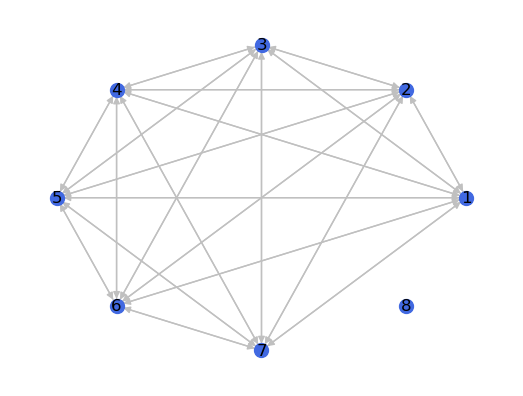

In [3]:
n = 8

G_hat=nx.DiGraph()
H=nx.path_graph(n)
G_hat.add_nodes_from(H)

angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
positions = {i: (np.cos(angle), np.sin(angle)) for i, angle in enumerate(angles)}

custom_labels = {i: f'{i + 1}' for i in range(n)}

for i in range(n-1):
    for j in range(n-1):
        G_hat.add_edges_from([[i,j]])
nx.draw_networkx(G_hat,pos=positions,node_color='royalblue',edge_color='silver',width=1,node_size=100,with_labels=True,labels=custom_labels)
plt.axis('off')
plt.show()

In [32]:
A = np.array([[1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], 
                       [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0],
                      [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0],
                      [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], [0,0,0,0,0,0,0,1]])
A[:n-1,:n-1] = A[:n-1,:n-1] + np.random.normal(0,0.05,[n-1,n-1])
A[n-1:,n-1:] = A[n-1:,n-1:] + np.random.normal(0,0.05,[1,1])

Sigma = np.diag(np.ones(n))

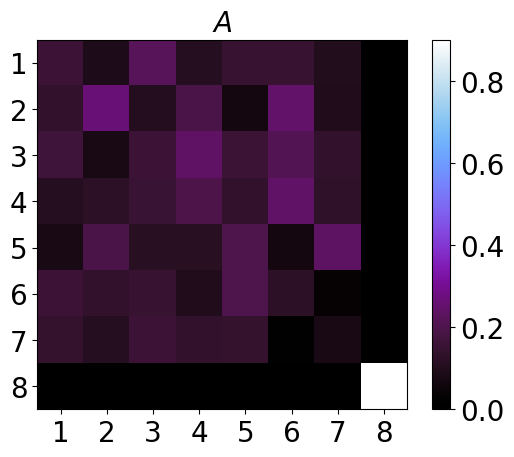

In [33]:
plt.imshow(A,cmap = "cmr.voltage")
plt.title('$A$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.yticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.savefig('./Figure/Gaussian_markov_matrix_A.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [34]:
P,S,Q = np.linalg.svd(A.T@np.linalg.inv(Sigma)@A)

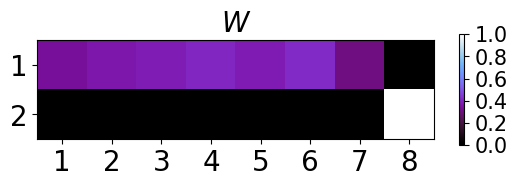

In [35]:
W = P[:,:2].T
plt.imshow(abs(W),cmap = "cmr.voltage")
plt.title('$W$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(8), np.arange(1, 9),fontsize = 20)
plt.yticks(np.arange(2), np.arange(1, 3),fontsize = 20)
plt.colorbar(shrink=0.3).ax.tick_params(labelsize=15)
plt.savefig('./Figure/W_Gaussian_markov.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [36]:
epsilon, rk_eps = calculate_threshold(A,Sigma)

In [37]:
epsilon

0.05347630140898691

In [38]:
gamma(1,rk_eps,A,Sigma)/rk_eps-gamma(1,n,A,Sigma)/n

0.8441831818670481

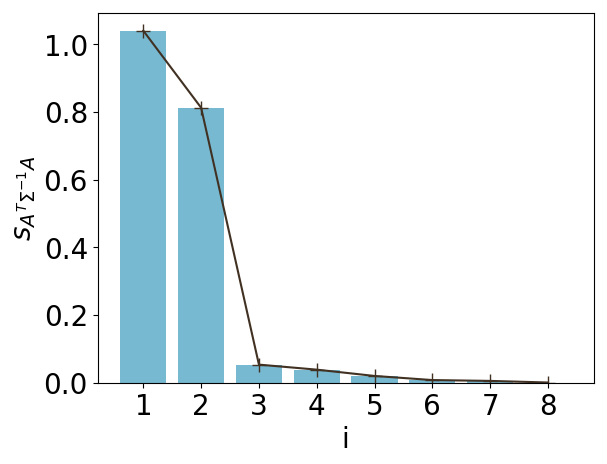

In [39]:
colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']

plt.bar([1,2,3,4,5,6,7,8],S,color = colors[4])
plt.plot([1,2,3,4,5,6,7,8],S,color = colors[5],marker ='+',markersize =10)
plt.xlabel('i',fontsize=20)
plt.ylabel('$s_{A^T\Sigma^{-1}A}$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.hlines(2,0.5,8.5,linestyles='--')
plt.savefig('./Figure/Gaussian_markov_SVD_clear.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

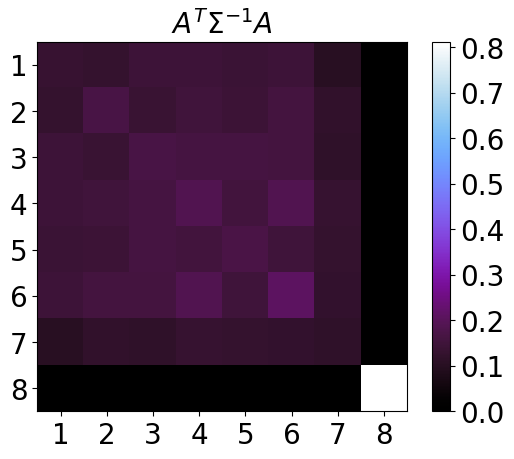

In [40]:
plt.imshow(A.T@np.linalg.inv(Sigma)@A,cmap = "cmr.voltage")
plt.title('$A^T\Sigma^{-1}A$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.yticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.savefig('./Figure/Gaussian_markov_matrix.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [50]:
A = np.array([[1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], 
                       [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0],
                      [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0],
                      [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0], [0,0,0,0,0,0,0,1]])
A[:n-1,:n-1] = A[:n-1,:n-1] + np.random.normal(0,0.05,[n-1,n-1])
A[n-1:,n-1:] = A[n-1:,n-1:] + np.random.normal(0,0.05,[1,1])

Sigma = np.diag(np.ones(n))

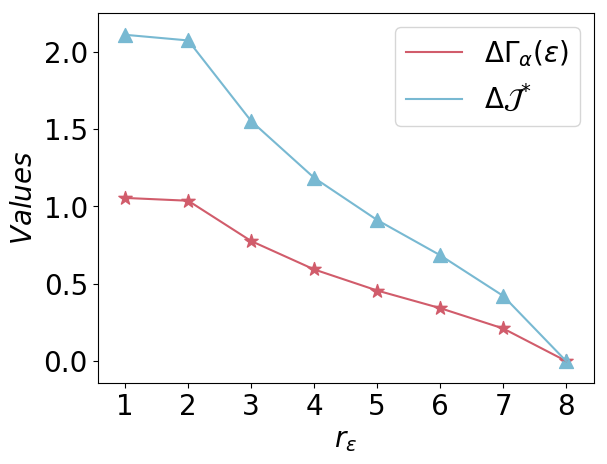

In [52]:
colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']

n = 8
rs = [1,2,3,4,5,6,7,8]
EIs = []
Gammas = []
rks = []
for rk in rs:
    Gammas.append(gamma(1,rk,A,Sigma)/rk-gamma(1,n,A,Sigma)/n)
    EIs.append(EI_calculate_m_star(A,Sigma,rk)/rk-EI_calculate_pdet(A,Sigma)/n)
    rks.append(rk)
plt.plot(rs,Gammas,label='$\Delta\Gamma_\\alpha(\epsilon)}$',color=colors[1])
plt.scatter(rs,Gammas,marker='*',color=colors[1],s=100)
plt.plot(rs,EIs,label='$\Delta\mathcal{J}^{*}}$',color=colors[4])
plt.scatter(rs,EIs,marker='^',color=colors[4],s=100)
plt.legend(fontsize=20)
plt.xlabel('$r_\epsilon$',fontsize=20)
plt.ylabel('$Values$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('./Figure/Gaussian_markov_emergence_and_r.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

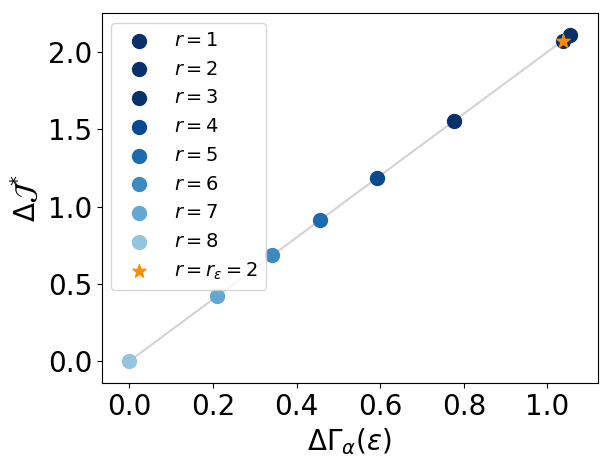

In [53]:
cmap = plt.get_cmap('Blues_r')
# 根据纵坐标设置颜色

n = 8
rs = [1,2,3,4,5,6,7,8]

color_map = cmap(-0.4+np.array(rs)/8)
EIs = []
Gammas = []
rks = []
for rk in rs:
    Gammas.append(gamma(1,rk,A,Sigma)/rk-gamma(1,n,A,Sigma)/n)
    EIs.append(EI_calculate_m_star(A,Sigma,rk)/rk-EI_calculate_pdet(A,Sigma)/n)
    rks.append(rk)

plt.plot(Gammas,EIs,color='lightgrey',zorder=1)
for rk in rs:  
    plt.scatter(Gammas[rk-1],EIs[rk-1],label='$r=%s$'%rk,color=color_map[rk-1],s=100,zorder=2)
plt.scatter(Gammas[1],EIs[1],label='$r=r_\epsilon=2$',color='darkorange',marker = '*',s=100,zorder=2)
plt.ylabel('$\Delta\mathcal{J}^{*}$',fontsize=20)
plt.xlabel('$\Delta\Gamma_\\alpha(\epsilon)}$',fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('./Figure/Gaussian_markov_eps.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [15]:
n = 8
A = np.array([[0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25],
       [0.25, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.25, 0.  , 0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.25, 0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.25],
       [0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ]])
Sigma = np.diag(np.ones(n))

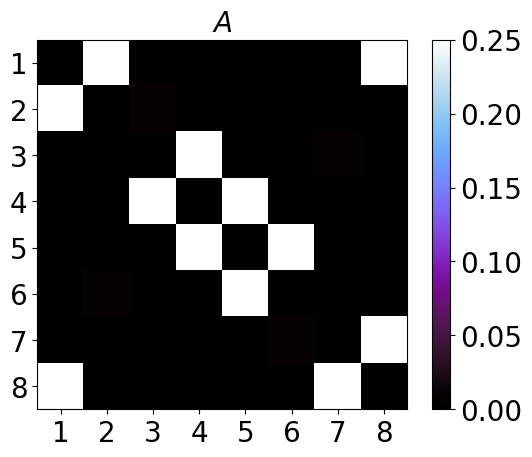

In [16]:
plt.imshow(A,cmap = "cmr.voltage")
plt.title('$A$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.yticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
#plt.savefig('./Figure/Gaussian_markov_matrix_A.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

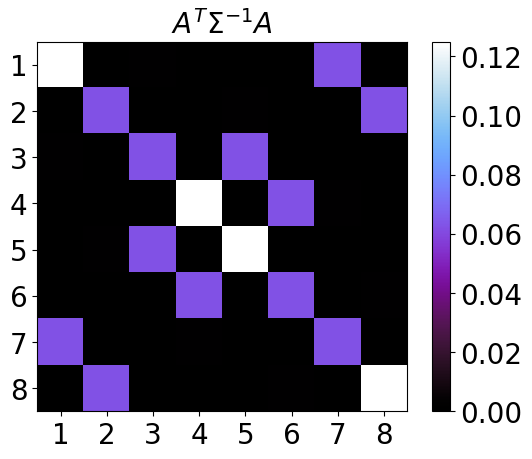

In [17]:
plt.imshow(A.T@np.linalg.inv(Sigma)@A,cmap = "cmr.voltage")
plt.title('$A^T\Sigma^{-1}A$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.yticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
#plt.savefig('./Figure/Gaussian_markov_matrix.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [18]:
P,S,Q = np.linalg.svd(A.T@np.linalg.inv(Sigma)@A)

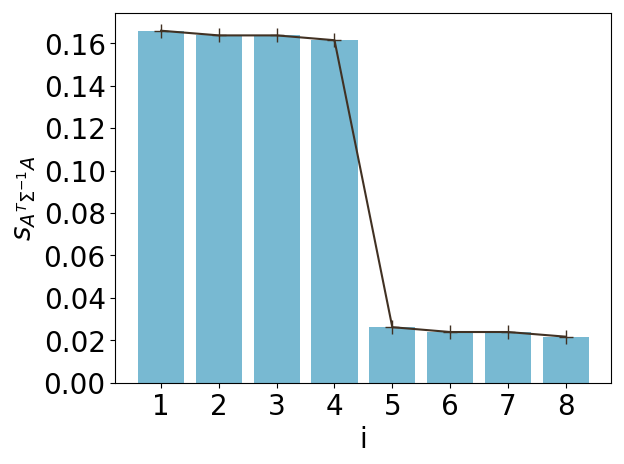

In [19]:
colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']

plt.bar([1,2,3,4,5,6,7,8],S,color = colors[4])
plt.plot([1,2,3,4,5,6,7,8],S,color = colors[5],marker ='+',markersize =10)
plt.xlabel('i',fontsize=20)
plt.ylabel('$s_{A^T\Sigma^{-1}A}$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.hlines(2,0.5,8.5,linestyles='--')
#plt.savefig('./Figure/Gaussian_markov_SVD_clear.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

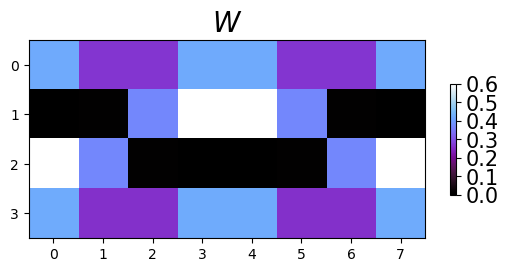

In [20]:
W = P.T[:4]
plt.imshow(abs(W),cmap = "cmr.voltage")
plt.title('$W$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
#plt.xticks(np.arange(8), np.arange(1, 9),fontsize = 20)
#plt.yticks(np.arange(2), np.arange(1, 3),fontsize = 20)
plt.colorbar(shrink=0.3).ax.tick_params(labelsize=15)
#plt.savefig('./Figure/W_Gaussian_markov.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()